# Speaker count Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/speaker-count](https://github.com/huseinzol05/malaya-speech/tree/master/example/speaker-count).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on Musan Speech, VCTK, LibriSpeech, Mandarin speakers and Malaya-Speech TTS dataset to detect number of speakers.

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

2023-09-01 12:10:43.857159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 12:10:45.110317: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 12:10:46.035942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-01 12:10:46.035979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

/home/husein/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [3]:
y, sr = malaya_speech.load('speech/vctk/p300_298_mic1.flac')
len(y) / sr

5.2068125

In [4]:
from datasets import Audio

y2, sr = malaya_speech.load('speech/podcast/toodia.mp3')

len(y2) / 16000

60.0

In [5]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)

In [6]:
ipd.Audio(y2, rate = sr)

### List available Nemo models

In [7]:
malaya_speech.is_clean.available_nemo()

,original from,Size (MB)
huseinzol05/nemo-is-clean-speakernet,https://catalog.ngc.nvidia.com/orgs/nvidia/tea...,16.2
huseinzol05/nemo-is-clean-titanet_large,https://catalog.ngc.nvidia.com/orgs/nvidia/tea...,88.8


### Load Nemo model

```python
def nemo(
    model: str = 'huseinzol05/nemo-speaker-count-speakernet',
    **kwargs,
):
    """
    Load Nvidia Nemo speaker count model.
    Trained on 300 ms frames.

    Parameters
    ----------
    model : str, optional (default='huseinzol05/nemo-speaker-count-speakernet')
        Check available models at `malaya_speech.speaker_count.available_nemo()`.

    Returns
    -------
    result : malaya_speech.torch_model.nemo.Classification class
    """
```

In [8]:
model = malaya_speech.speaker_count.nemo(model = 'huseinzol05/nemo-speaker-count-titanet_large')

In [9]:
_ = model.eval()

### How to use Speaker Count detection

We finetuned nemo models on 300 ms frame.

In [10]:
frames = list(malaya_speech.utils.generator.frames(y, 300, sr, False))

In [11]:
%%time

probs = [(frame, model.predict([frame])[0]) for frame in frames]

CPU times: user 7.1 s, sys: 72.4 ms, total: 7.18 s
Wall time: 992 ms


2023-09-01 12:14:17.946627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 12:14:17.957400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-01 12:14:17.957442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: husein-MS-7D31
2023-09-01 12:14:17.957445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: husein-MS-7D31
2023-09-01 12:14:17.957725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.199.2
2023-09-01 12:14:17.957751: I tensorflow/compi

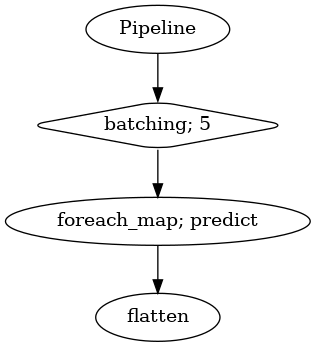

In [13]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [14]:
result = p.emit(frames)
result.keys()

/home/husein/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=480
  return f(*args, **kwargs)
2023-09-01 12:14:19.769920: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
/home/husein/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=269
  return f(*args, **kwargs)


dict_keys(['batching', 'predict', 'flatten'])

In [15]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)
grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

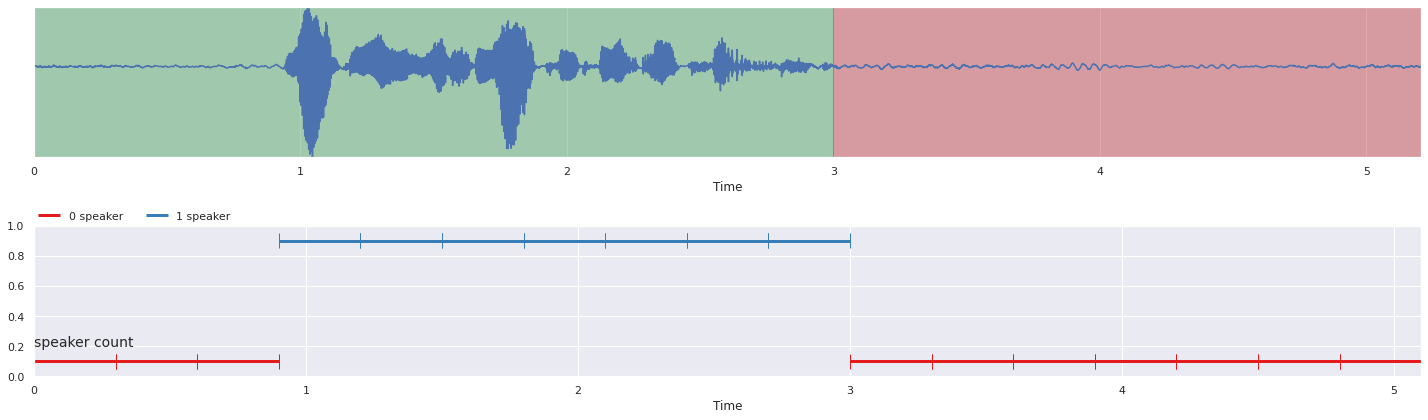

In [17]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(probs, 'speaker count', 
                                                      yaxis = True, ax = ax[1])
fig.tight_layout()
plt.show()

In [18]:
frames = list(malaya_speech.utils.generator.frames(y2, 300, sr, False))

In [19]:
%%time

probs = [(frame, model.predict([frame])[0]) for frame in frames]

CPU times: user 1min 14s, sys: 994 ms, total: 1min 15s
Wall time: 7.35 s


/home/husein/dev/malaya-speech/malaya_speech/utils/featurization.py:38: FutureWarning: Pass sr=16000, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  self.mel_basis = librosa.filters.mel(


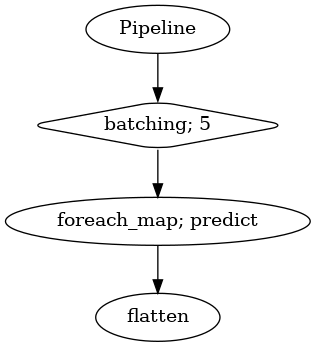

In [20]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')
frames = list(malaya_speech.utils.generator.frames(y2, 30, sr))
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [21]:
result = p.emit(frames)
result.keys()

/home/husein/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=480
  return f(*args, **kwargs)


dict_keys(['batching', 'predict', 'flatten'])

In [22]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)
grouped_vad = malaya_speech.utils.group.group_frames(grouped_vad)

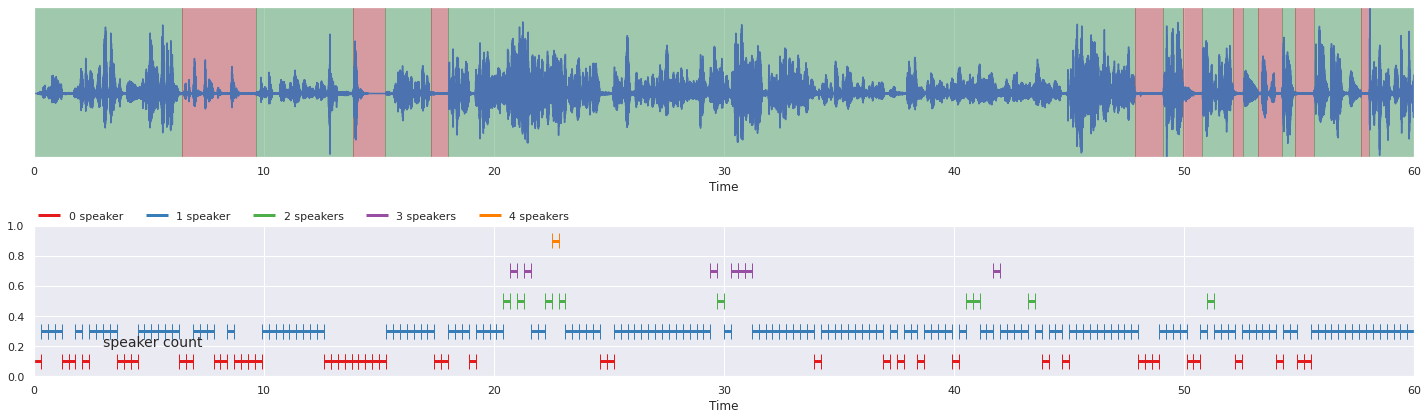

In [23]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y2, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(probs, 'speaker count', 
                                                      yaxis = True, ax = ax[1])
fig.tight_layout()
plt.show()

In [24]:
ipd.Audio(y2[20 * sr: 30 * sr], rate = sr)